In [1]:
import sys
sys.path.append('..')

import os
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )
#PATH_SHP_RECORRIDOS = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\RECORRIDOS.shp'
#GDF_RECORRIDOS = gpd.read_file(PATH_SHP_RECORRIDOS)

<Axes: >

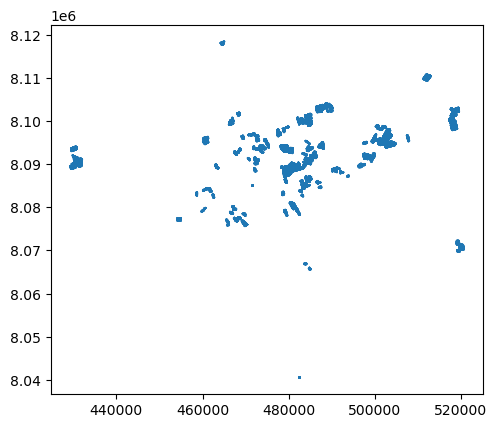

In [2]:
GDF_RECORRIDOS = gpd.read_postgis(
    "SELECT * FROM drones_pulverizacion.recorridos_dron_pulv", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

GDF_RECORRIDOS.plot()

In [3]:
def obtener_parte_diario_sin_cod_labor():
    engine = obtener_engine()
    try:
        query = """
            SELECT DISTINCT idd, unidad_01, unidad_02
            FROM drones_pulverizacion.parte_diario_pulv 
            WHERE idd IS NOT NULL AND cod_labor IS NULL
        """
        # Usar pandas si no hay geometría involucrada
        df = pd.read_sql(query, engine)
        return df
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return pd.DataFrame()

def obtener_propiedad_por_idd(idd):
    engine = obtener_engine()
    try:
        query = f"""
            SELECT * FROM drones_pulverizacion.parte_diario_pulv WHERE idd= {idd}
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

def actualizar_area_rociada(id, val):
    engine = obtener_engine()
    try:
        with engine.begin() as conn:
            query = text("""
                UPDATE drones_pulverizacion.parte_diario_pulv
                SET 
                    area_rocia= :val
                WHERE id = :id
            """)
            conn.execute(query, {"id": id, "val": val})
            print(f"✔️ Area rociada actualizada de lote id: {id}")
    except Exception as e:
        print(f"❌ Error al actualizar: {e}")

def actualizar_faltantes_por_idd(idd, fecha_intermedia, fecha_min, fecha_max, numero_semana, num_vuelos, total_flight_time, total_caudal, drone):
    engine = obtener_engine()
    try:
        with engine.begin() as conn:
            query = text("""
                UPDATE drones_pulverizacion.parte_diario_pulv
                SET 
                    fecha= :fecha_intermedia,
                    hora_ini= :fecha_min,
                    hora_fin= :fecha_max,
                    semana= :numero_semana,
                    num_vuelos= :num_vuelos,
                    horas_vuel= :total_flight_time,
                    total_caud= :total_caudal,
                    id_dron= :drone
                WHERE idd = :idd
            """)
            conn.execute(query, {
                "idd": idd, 
                "fecha_intermedia": fecha_intermedia,
                "fecha_min": fecha_min,
                "fecha_max": fecha_max,
                "numero_semana": numero_semana,
                "num_vuelos": num_vuelos,
                "total_flight_time": total_flight_time,
                "total_caudal": total_caudal,
                "drone": drone
            })
            print(f"✔️ Datos faltantes de idd: {idd} cargados correctamente")
    except Exception as e:
        print(f"❌ Error al actualizar: {e}")

In [4]:
propiedades_procesar = obtener_parte_diario_sin_cod_labor()
propiedades_procesar

,idd,unidad_01,unidad_02
0,107,256,LOS ANDES--AGUILERA
1,105,19,SANTA BARBARA
2,106,1618,MONTE REY I--ROCA MAURICIO


In [5]:
for i, row in propiedades_procesar.iterrows():
    idd = row.idd
    selec_recorridos = GDF_RECORRIDOS[GDF_RECORRIDOS['idd']==idd].copy()
    if (len(selec_recorridos) == 0):
        continue
    # selccion de lotes planificados
    selec_plan = obtener_propiedad_por_idd(idd).copy()
    # conviente en campo fecha a formato fecha
    selec_recorridos.loc[:, "fecha"] = pd.to_datetime(selec_recorridos["fecha"])
    # Obtener la fecha mínima y máxima
    fecha_min = selec_recorridos["fecha"].min()
    fecha_max = selec_recorridos["fecha"].max()
    fecha_intermedia = fecha_min + (fecha_max - fecha_min) / 2
    numero_semana = fecha_intermedia.isocalendar().week
    area_total_pulv = selec_recorridos['area'].sum()
    num_vuelos = len(selec_recorridos)
    total_caudal = selec_recorridos['spray'].sum()
    drone = selec_recorridos.iloc[0]['drone']
    
    selec_recorridos = selec_recorridos.copy()
    
    # obtener horas de vuelo en formto 00:00:00
    selec_recorridos["fl_time_sec"] = selec_recorridos["fl_time"].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1]))
    # Sum all seconds
    total_seconds = selec_recorridos["fl_time_sec"].sum()
    # Convert back to hh:mm:ss format
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    total_flight_time = f"{hours:02}:{minutes:02}:{seconds:02}"  # 00:00:00

    # Aplicar el buffer a la geometría de los recorridod
    selec_recorridos["geom"] = selec_recorridos.geometry.buffer(5.5)
    # Disolver todas las geometrías en un solo polígono
    buffer_dissolved = selec_recorridos.dissolve()
    # Calcular la intersección
    interseccion = gpd.overlay(buffer_dissolved, selec_plan, how="intersection")
    # Calcular el área de cada polígono de la intersección
    interseccion["area_rociado"] = interseccion.geometry.area / 10000
    # seleccion solo de la columnas de interes
    resumen = interseccion[['id_2', 'unidad_05', 'area_2', 'area_rociado']].copy()
    
    # PROCEDIMIENTO PARA AJUSTAR EL AREA DE ROCIADO
    suma_area_rociada = resumen['area_rociado'].sum()
    area_rociada_real = area_total_pulv  # aquí pon tu valor real
    # Factor inicial de ajuste
    factor_ajuste = area_rociada_real / suma_area_rociada
    # Ajuste proporcional inicial
    resumen['area_ajustada'] = resumen['area_rociado'] * factor_ajuste
    # Verificar que no exceda area_2 y corregir iterativamente si es necesario
    while any(resumen['area_ajustada'] > resumen['area_2']):
        exceso = resumen['area_ajustada'] > resumen['area_2']
        resumen.loc[exceso, 'area_ajustada'] = resumen.loc[exceso, 'area_2']
        # Recalcular factor solo con las filas no ajustadas al máximo permitido
        area_ajustada_parcial = resumen.loc[~exceso, 'area_ajustada'].sum()
        area_restante = area_rociada_real - resumen.loc[exceso, 'area_ajustada'].sum()
        # Evitar división por cero
        if area_ajustada_parcial == 0:
            break
        nuevo_factor = area_restante / area_ajustada_parcial
        resumen.loc[~exceso, 'area_ajustada'] *= nuevo_factor
    # calcular campos faltantes
    resumen["porcen_rociado"] = (resumen["area_ajustada"]) / (resumen["area_2"])
    resumen["dif_area"] = resumen["area_2"] - resumen["area_ajustada"]
    # recorrer resumen para actualizar area rociada en el parte diario
    for i, row in resumen.iterrows():
        print(row.id_2, row.area_ajustada)
        actualizar_area_rociada(row.id_2, row.area_ajustada)
    # cargar campos restantes del parte con respecto a idd
    actualizar_faltantes_por_idd(idd, fecha_intermedia, fecha_min, fecha_max, numero_semana, num_vuelos, total_flight_time, total_caudal, drone)

991 10.397205539407326
✔️ Area rociada actualizada de lote id: 991
995 10.852076240171872
✔️ Area rociada actualizada de lote id: 995
990 22.290286790820183
✔️ Area rociada actualizada de lote id: 990
994 7.589022181717572
✔️ Area rociada actualizada de lote id: 994
993 27.08236142617188
✔️ Area rociada actualizada de lote id: 993
996 14.64846781786939
✔️ Area rociada actualizada de lote id: 996
992 26.029967014966935
✔️ Area rociada actualizada de lote id: 992
997 28.931147586559554
✔️ Area rociada actualizada de lote id: 997
998 10.303064517634857
✔️ Area rociada actualizada de lote id: 998
999 30.51906849256045
✔️ Area rociada actualizada de lote id: 999
✔️ Datos faltantes de idd: 107 cargados correctamente
1007 0.8080394031058895
✔️ Area rociada actualizada de lote id: 1007
1006 5.075220837504145
✔️ Area rociada actualizada de lote id: 1006
1009 9.506786541604566
✔️ Area rociada actualizada de lote id: 1009
1010 10.656041283686406
✔️ Area rociada actualizada de lote id: 1010
1015 1